In [1]:
import pandas as pd 
import numpy as np
import os 
import json
from math import ceil, floor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2

from sklearn.preprocessing import LabelEncoder,scale
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.utils.multiclass import unique_labels

from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})

import re
import nltk
from nltk.corpus import stopwords


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, Dropout, GlobalMaxPooling1D
from keras.metrics import categorical_accuracy
from keras.callbacks import  EarlyStopping


Using TensorFlow backend.


In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
Number_RE = re.compile('[*^0-9]')
Bad_underline = re.compile('[*_*]')
RemoveTag = re.compile('&lt;|br&gt;|b&gt;|ul&gt;|li&gt;')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = RemoveTag.sub('',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = Number_RE.sub(' ', text) # replace Number symbols by space in text
    text = Bad_underline.sub(' ', text) # replace Underline symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
RemoveLastSpace = re.compile(' $')

def clean_text_category(text):
    text = RemoveLastSpace.sub('',text)
    return text
    

In [3]:
def classNumberThreshold(arr):
    dropCategory = []

    for key,value in arr.items():
        if(value<=30):
            dropCategory.append(key)
    return dropCategory

In [4]:
df = pd.read_csv('../../example/combine.csv')

In [5]:
def checkNanin(text):
    text = str(text)
    if(text=="nan"):
        return ""
    else:
        return text
df.description = df.description.apply(checkNanin)  
df.description = df['description'].apply(clean_text)
df = df[pd.notnull(df['category'])]
df = df[pd.notnull(df['uniq_id'])]
df = df[pd.notnull(df['description'])]
df = df.dropna(subset=['description'])


In [6]:
dropCategoryCode  = classNumberThreshold(df.category.value_counts())
dropSubCategoryCode  = classNumberThreshold(df.subcategory.value_counts())

for i in dropCategoryCode:
    df = df[df.category!=i]
    
for i in dropSubCategoryCode:
    df = df[df.subcategory!=i]



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28540 entries, 0 to 28689
Data columns (total 8 columns):
uniq_id          28540 non-null object
product_name     28540 non-null object
description      28540 non-null object
category_main    27101 non-null object
category_sub1    27101 non-null object
category_sub2    23396 non-null object
category         28540 non-null int64
subcategory      28540 non-null int64
dtypes: int64(2), object(6)
memory usage: 2.0+ MB


In [8]:
le = LabelEncoder()
le.fit(df.category)
target = le.classes_
labels = le.transform(df.category)

le.fit(df.subcategory)
subtarget = le.classes_
sublabels = le.transform(df.subcategory)

In [9]:
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df.description)
featureNames = tfidfconverter.get_feature_names()

In [10]:
X_train, X_test, y_train_info, y_test_info = train_test_split(X, pd.DataFrame({'index':df.index, 'label':labels}), 
                                                    test_size=0.1, random_state = 27)

In [11]:
y_train = y_train_info.label
y_test = y_test_info.label


In [12]:
model = LinearSVC(random_state=42,class_weight="balanced")
model.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [13]:
target = [ str(ele) for ele in target]
subtarget = [ str(ele) for ele in subtarget]

classWithInfluence = {}

coef = model.coef_
coef = scale(coef)

coefTotalSize = coef.shape[0]*coef.shape[1]
coef1DArr = coef.reshape(coefTotalSize,1)
Max = ceil(max(coef1DArr[0]))
Min = floor(min(coef1DArr[0]))

for index in range(0,len(coef)):
    normalisedCoef = [round((ele-Min)/(Max-Min),2) for ele in coef[index]]
    name = featureNames
    classWithInfluence[target[index]] = list(zip(name,normalisedCoef))
            
Top10InflunceFeature = {}
for key, value in classWithInfluence.items():
    Top10InflunceFeature[key] = sorted(value, key=lambda x: x[1], reverse=True)[:10]

with open('Combine/CompanyTopFeatureByClass.json', 'w') as json_file:
    json.dump(Top10InflunceFeature, json_file, indent=2)    

In [14]:
selectBest = SelectKBest(chi2, k= len(target)*10).fit(X_train, y_train)

originScore = selectBest.scores_
supportsList = selectBest.get_support()
Max = ceil(max(originScore))
Min = floor(min(originScore))
Normscores = [round((ele-Min)/(Max-Min),2) for ele in originScore]
scoreDict = dict(zip(featureNames,
                     list(zip(supportsList, Normscores))))
newScoreDict = {}

for key , item in scoreDict.items():
    if(item[0]):
        newScoreDict[key] = item[1]

ranksfeaturesDict = pd.DataFrame({"Feature":list(newScoreDict.keys()),
                                  "Score":list(newScoreDict.values())},dtype=np.int64)
ranksfeaturesDict = ranksfeaturesDict.sort_values(by=['Score'],ascending=False)
ranksfeaturesDict.to_csv("Combine/RankByTotalFeatureAmazon.csv",index=False,compression=None)

In [15]:
BestSize  = [ele for ele in range(100, len(featureNames), 100) ]
Models = []
Scores = []
SelectModels  = []
for ele in range(100, len(featureNames), 100):
    print("--- Best "+ str(ele) + " features \n")
    selectBest = SelectKBest(chi2, k= ele)
    model = LinearSVC(random_state=42,class_weight="balanced")
    K_best_linearsvc = Pipeline([('SelectBest', selectBest), ('linearSVC', model)])
    K_best_linearsvc.fit(X_train,y_train)
    score = K_best_linearsvc.score(X_test,y_test)
    Models.append(K_best_linearsvc)
    Scores.append(score)

bestModel = Models[np.argmax(Scores)]
bestSize = BestSize[np.argmax(Scores)]

# save the model to disk
filename = 'Combine/'+str(bestSize)+'BestLinearSVC.sav'
joblib.dump(bestModel, filename)



yConfidence = bestModel.decision_function(X_test)

yPred = bestModel.predict(X_test)


--- Best 100 features 

--- Best 200 features 

--- Best 300 features 

--- Best 400 features 

--- Best 500 features 

--- Best 600 features 

--- Best 700 features 

--- Best 800 features 

--- Best 900 features 

--- Best 1000 features 

--- Best 1100 features 

--- Best 1200 features 

--- Best 1300 features 

--- Best 1400 features 

--- Best 1500 features 

--- Best 1600 features 

--- Best 1700 features 

--- Best 1800 features 

--- Best 1900 features 

--- Best 2000 features 

--- Best 2100 features 

--- Best 2200 features 

--- Best 2300 features 

--- Best 2400 features 

--- Best 2500 features 

--- Best 2600 features 

--- Best 2700 features 

--- Best 2800 features 

--- Best 2900 features 

--- Best 3000 features 

--- Best 3100 features 

--- Best 3200 features 

--- Best 3300 features 

--- Best 3400 features 

--- Best 3500 features 

--- Best 3600 features 

--- Best 3700 features 

--- Best 3800 features 

--- Best 3900 features 

--- Best 4000 features 

--- Best 

In [16]:
totalConfidenceSize = yConfidence.shape[0]*yConfidence.shape[1]
Confidence1DArr = yConfidence.reshape(totalConfidenceSize,1)
Max = ceil(max(Confidence1DArr)[0])
Min = floor(min(Confidence1DArr)[0])
NormalisedConfid = [round((max(ele)-Min)/(Max-Min),2) for ele in yConfidence]
productID = [ df[df.index==ele]['uniq_id'].values[0] for ele in y_test_info['index'] ]
ProductDescription =[ df[df.index==ele]['description'].values[0] for ele in y_test_info['index'] ]
LinearSVCResult = pd.DataFrame({'id':productID,'description':ProductDescription,
                         'trueClass': y_test,'trueClassNaem':[target[e] for e in y_test] ,
                         'predictClass':yPred,'predictClassName':[target[e] for e in yPred],
                         'Confidence':NormalisedConfid})
LinearSVCResult.to_csv("Combine/SVCResults.csv",index=False,compression=None)

In [18]:
target = [str(ele) for ele in target]
print(classification_report(y_test, yPred,target_names=target))
with open('Combine/SVCReport.txt', 'w') as file:
    file.write(classification_report(y_test, yPred,target_names=target))

              precision    recall  f1-score   support

      100000       0.98      0.98      0.98        89
      110000       0.81      0.76      0.78        38
      200000       0.86      0.84      0.85        45
      300000       0.96      0.94      0.95        77
      400000       0.97      0.99      0.98       160
      500000       0.99      0.99      0.99      1276
      700000       0.98      0.99      0.98       313
      800000       0.98      0.98      0.98       829
      900000       1.00      0.93      0.96        27

   micro avg       0.98      0.98      0.98      2854
   macro avg       0.95      0.93      0.94      2854
weighted avg       0.98      0.98      0.98      2854



In [19]:
cm = confusion_matrix(y_test, yPred)

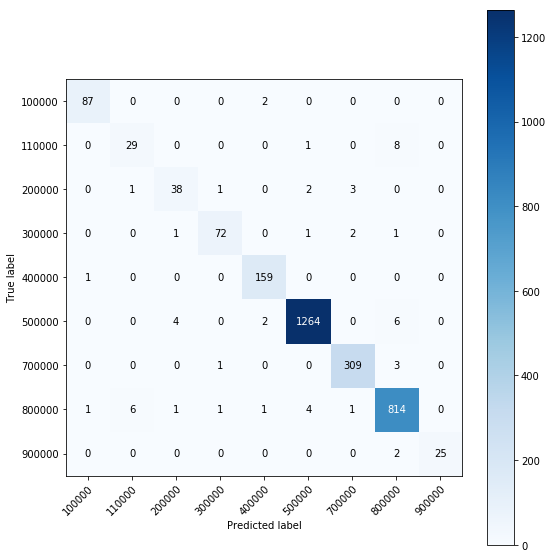

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
im =ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
classes = target
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,ylabel='True label',xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
fig.savefig("Combine/LinearSVCConfusionMatrix.png")

In [128]:
def draw_confidenceReport(data):
    num = [ ele*0.01 for ele in range(20,81,2)]
    totalitems = []
    correct = []
    incorrect = []
    for ele in num:
        Threshold = data[data.Confidence>ele]
        correct.append(len(Threshold[Threshold['trueClass']==Threshold['predictClass']].index))
        incorrect.append(len(Threshold[Threshold['trueClass']!=Threshold['predictClass']].index))
        totalitems.append(len(Threshold.index))
    
    ClassfiedProportion = [ ele/len(data.index) for ele in totalitems]
    
    Acc =[]
    for ele in zip(correct,totalitems):
        if (ele[1]==0):
            Acc.append(0)
        else:
            Acc.append(ele[0]/ele[1])

    fig,ax  = plt.subplots()
    
    color = 'tab:blue'
    ax.scatter(num,ClassfiedProportion,label="Proportion classified",color=color)
    ax.set_xlabel("Confidence Score")
    ax.set_ylabel("Proportion classified", color=color)
    ax.xaxis.set_ticks(np.arange(0,1.1,0.1))
#     ax.set_ylim(-0.1,1.1,0.1)
    ax.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.scatter(num,Acc,label="Accuracy", color=color)
    ax2.set_ylabel("Accuracy", color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0.979,1.001,0.001)

    ax2.yaxis.set_ticks(np.arange(0.98,1,0.005))
    fig.savefig("Combine/ConfidenceScoreReportSVC.png")

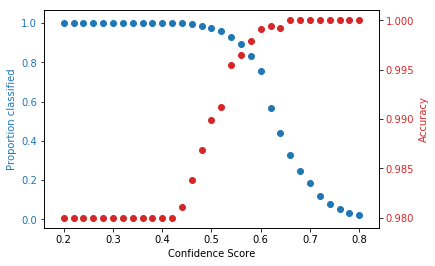

In [129]:
draw_confidenceReport(LinearSVCResult)

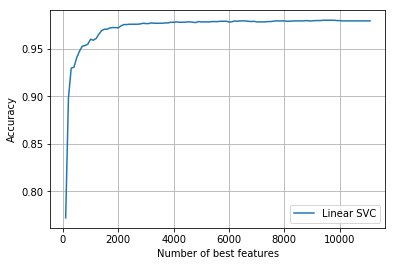

In [25]:
fig,ax  = plt.subplots()
ax.plot(BestSize,Scores,label="Linear SVC")
ax.set_xlabel("Number of best features")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.savefig("Combine/linearsvcbestFeatureSize.png")